In [235]:
import glob
import os
import pickle
from scipy.stats import bernoulli

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rc
from xgboost import XGBRegressor

import xgboost as xgb
import scikitplot as skplt
import scipy.stats as st

# from google.colab import drive
# # mount google drive information in a google colaboratory directory
# drive.mount('/content/gdrive')

# path = r'gdrive/My Drive/Trabajos DS/Data/' # path
path = 'home\Documents\Personal\MIMYANALYTICS\TESIS\TESIS\datasets' #C:\Users\dlongas


In [140]:
#Funciones Útiles
def plot_roc(label, pred):
    """
    Grafica curva ROC
    """
    fpr, tpr, thresholds = roc_curve(label, pred)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, label="AUC %.4f" % roc_auc_score(label, pred))
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.legend(loc="lower right")
    # show the plot
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
    
def gap_metricas(prior_mujer, y_proba, y_test, gap = .09):
        
    threshold_m = prior_mujer + gap
    threshold_h = prior_mujer - gap

    prec_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_proba > threshold_m).sum()
    recall_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_test==1).sum()
    f1_m = prec_m * recall_m * 2 / (prec_m + recall_m )

    prec_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_proba < threshold_h).sum()
    recall_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_test == 0).sum()
    f1_h = prec_h * recall_h * 2 / (prec_h + recall_h )

    print("Porcentaje del total: "+str(round(100*len(y_proba[(y_proba>threshold_m) | (y_proba<threshold_h)])/len(y_proba),2)))
    print("Hombres: precision = %.4f - recall = %.4f - f1 = %.4f " % (prec_h, recall_h, f1_h))
    print("Mujeres: precision = %.4f - recall = %.4f - f1 = %.4f "% (prec_m, recall_m, f1_m)) 
    
    
def precision_recall_curve_hombre(y_test,y_proba):
    precision, recall, thresholds = precision_recall_curve(y_test,y_proba)
    precision = precision[:-1]
    recall = recall[:-1]
    plt.plot(thresholds, precision, label = 'precision (label = 1)')
    plt.plot(thresholds, recall, label = 'recall (label = 1)')   
    plt.xlabel('thresholds (score= prob hombre)')
    plt.legend(loc="lower left")
    plt.show()
    
    
def precision_recall_curve_mujer(y_test,y_proba):
    precision, recall, thresholds = precision_recall_curve(1 - y_test, 1- y_proba)
    precision = precision[:-1]
    recall = recall[:-1]
    plt.plot(thresholds, precision, label = 'precision (label = 0)')
    plt.plot(thresholds, recall, label = 'recall (label = 0)')   
    plt.xlabel('thresholds (score= prob mujer)')
    plt.legend(loc="lower left")
    plt.show()
    
    
def precision_metricas(prior_mujer, y_proba, y_test, prec_esperada = .80, hombre_eval=1):
    
    for gap in list(np.linspace(0, 0.5, 100)):
        threshold_m = prior_mujer + gap
        threshold_h = prior_mujer - gap
        if((threshold_m > 1)|(threshold_h<0)):
            print('No se pudo encontrar datos con ese nivel de precisión.')
            break
        else:
            prec_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_proba > threshold_m).sum()
            recall_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_test==1).sum()
            f1_m = prec_m * recall_m * 2 / (prec_m + recall_m )

            prec_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_proba < threshold_h).sum()
            recall_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_test == 0).sum()
            f1_h = prec_h * recall_h * 2 / (prec_h + recall_h )
            
            if(((hombre_eval==1)&(prec_h>=prec_esperada))|((hombre_eval==0)&(prec_m>=prec_esperada))):
               print("Porcentaje del total: "+str(round(100*len(y_proba[(y_proba>threshold_m) | (y_proba<threshold_h)])/len(y_proba),2)))
               print("Hombres: precision = %.4f - recall = %.4f - f1 = %.4f " % (prec_h, recall_h, f1_h))
               print("Mujeres: precision = %.4f - recall = %.4f - f1 = %.4f "% (prec_m, recall_m, f1_m))
               break
    if (gap==0.5):
        print('No se pudo encontrar datos con ese nivel de precisión.')

        
def precision_top(y_proba, y_test, top=1000):    
    ref=list(y_proba)
    ref.sort()

    prec_m = ((y_proba>=ref[(-1*top)]) & (y_test==1)).sum() * 1. / (y_proba>=ref[(-1*top)]).sum()
    recall_m = ((y_proba>=ref[(-1*top)]) & (y_test==1)).sum() * 1. / (y_test==1).sum()

    prec_h = ((y_proba<=ref[top]) & (y_test==0)).sum() * 1. / (y_proba<=ref[top]).sum()
    recall_h = ((y_proba<=ref[top]) & (y_test==0)).sum() * 1. / (y_test==0).sum()

    print("Porcentaje del total: "+str(round(100*((len(y_proba[y_proba<=ref[top]])+
                                                   len(y_proba[y_proba>=ref[(-1*top)]]))/len(y_proba)),2)))
    print("Hombres: precision = %.4f - recall = %.4f " % (prec_h, recall_h))
    print("Mujeres: precision = %.4f - recall = %.4f "% (prec_m, recall_m))
    

In [222]:
#Descargo dataset final con feature engeneering
df = pd.read_csv('df_final_useragent.csv')
df = df.drop(['Unnamed: 0'], axis=1) #,'feature_type'
print('Dataset Size',df.shape)
df.head()

Dataset Size (89253, 80)


,ispc,istablet,ismobile,sistema_op_Linux,sistema_op_Mac OS X,sistema_op_SinDato,sistema_op_Windows,sistema_op_iOS,version_sistema_op_Android 4,version_sistema_op_Android 5,version_sistema_op_Android 6,version_sistema_op_Android 7,version_sistema_op_Android 8,version_sistema_op_Android 9,version_sistema_op_SinDato,version_sistema_op_Windows 10,version_sistema_op_Windows 7,version_sistema_op_Windows 8,version_sistema_op_Windows XP,version_sistema_op_iOS 13,version_sistema_op_iOS 14,navegador_Chrome,navegador_Edge,navegador_Firefox,navegador_Google,navegador_IE,navegador_Safari,navegador_SinDato,navegador_SocialApp,marca_ancient,marca_new,marca_old,modelo_Mac,modelo_Moto C,modelo_Moto E (4,modelo_Moto G (5,modelo_Moto G (5S,modelo_Samsung SM-A015M,modelo_Samsung SM-A105M,modelo_Samsung SM-A107M,modelo_Samsung SM-A115M,modelo_Samsung SM-A205G,modelo_Samsung SM-A207M,modelo_Samsung SM-A217M,modelo_Samsung SM-A305G,modelo_Samsung SM-A307G,modelo_Samsung SM-A315G,modelo_Samsung SM-A505G,modelo_Samsung SM-A515F,modelo_Samsung SM-A520F,modelo_Samsung SM-A705MN,modelo_Samsung SM-A715F,modelo_Samsung SM-G532M,modelo_Samsung SM-G570M,modelo_Samsung SM-G610M,modelo_Samsung SM-G935F,modelo_Samsung SM-G950F,modelo_Samsung SM-G955F,modelo_Samsung SM-G9600,modelo_Samsung SM-G9650,modelo_Samsung SM-G975F,modelo_Samsung SM-J260M,modelo_Samsung SM-J400M,modelo_Samsung SM-J415G,modelo_Samsung SM-J600G,modelo_Samsung SM-J610G,modelo_Samsung SM-J700M,modelo_Samsung SM-J701M,modelo_Samsung SM-J710MN,modelo_SinDato,modelo_XiaoMi Redmi Note 7,modelo_XiaoMi Redmi Note 8,modelo_iPhone,modelo_moto e5,modelo_moto e5 play,antig_ancient,antig_new,antig_old,device_idx,fem
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1.0,1
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2.0,0
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,4.0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,5.0,0


In [223]:
print('Clases')
print(df['fem'].value_counts())

Clases
1    47198
0    42055
Name: fem, dtype: int64


In [269]:
# get the dependent and the independents variables
X=df[['ispc', 'istablet', 'ismobile', 'sistema_op_Linux',
       'sistema_op_Mac OS X', 'sistema_op_SinDato', 'sistema_op_Windows',
       'sistema_op_iOS', 'version_sistema_op_Android 4',
       'version_sistema_op_Android 5', 'version_sistema_op_Android 6',
       'version_sistema_op_Android 7', 'version_sistema_op_Android 8',
       'version_sistema_op_Android 9', 'version_sistema_op_SinDato',
       'version_sistema_op_Windows 10', 'version_sistema_op_Windows 7',
       'version_sistema_op_Windows 8', 'version_sistema_op_Windows XP',
       'version_sistema_op_iOS 13', 'version_sistema_op_iOS 14',
       'navegador_Chrome', 'navegador_Edge', 'navegador_Firefox',
       'navegador_Google', 'navegador_IE', 'navegador_Safari',
       'navegador_SinDato', 'navegador_SocialApp', 'marca_ancient',
       'marca_new', 'marca_old', 'modelo_Mac', 'modelo_Moto C',
       'modelo_Moto E (4', 'modelo_Moto G (5', 'modelo_Moto G (5S',
       'modelo_Samsung SM-A015M', 'modelo_Samsung SM-A105M',
       'modelo_Samsung SM-A107M', 'modelo_Samsung SM-A115M',
       'modelo_Samsung SM-A205G', 'modelo_Samsung SM-A207M',
       'modelo_Samsung SM-A217M', 'modelo_Samsung SM-A305G',
       'modelo_Samsung SM-A307G', 'modelo_Samsung SM-A315G',
       'modelo_Samsung SM-A505G', 'modelo_Samsung SM-A515F',
       'modelo_Samsung SM-A520F', 'modelo_Samsung SM-A705MN',
       'modelo_Samsung SM-A715F', 'modelo_Samsung SM-G532M',
       'modelo_Samsung SM-G570M', 'modelo_Samsung SM-G610M',
       'modelo_Samsung SM-G935F', 'modelo_Samsung SM-G950F',
       'modelo_Samsung SM-G955F', 'modelo_Samsung SM-G9600',
       'modelo_Samsung SM-G9650', 'modelo_Samsung SM-G975F',
       'modelo_Samsung SM-J260M', 'modelo_Samsung SM-J400M',
       'modelo_Samsung SM-J415G', 'modelo_Samsung SM-J600G',
       'modelo_Samsung SM-J610G', 'modelo_Samsung SM-J700M',
       'modelo_Samsung SM-J701M', 'modelo_Samsung SM-J710MN', 'modelo_SinDato',
       'modelo_XiaoMi Redmi Note 7', 'modelo_XiaoMi Redmi Note 8',
       'modelo_iPhone', 'modelo_moto e5', 'modelo_moto e5 play',
       'antig_ancient', 'antig_new', 'antig_old']]
y = df['fem']

- Train: subconjunto para entrenar el modelo.
- Test: subconjunto para verificar que el modelo reproduce los resultados deseados.

In [270]:
# get train and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0,test_size =0.2)

Debido a problemas de escalas diferentes en distintas variables se suele estandarizar los datos, es decir restarle la media y dividir sobre la varianza.

In [271]:
#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

**MODELOS**

The problem involves a binary response variable (0: Male; 1: Female) so classification techniques need to be used to get the suitable model.

Logistic Regression, Random Forest and XGBoost will be used to predict if a devices is going to be female or not.

The main metrics which will be considered are Accuracy and Recall.

***Accuracy***: Is the fraction of all positive and negative instances that the classifier correctly identifies as positive and negative respectively. ((TN+TP)/(TN+TP+FN+FP))

***Recall***: Is the fraction of all positive instances that the classifier correctLy indentifies as positive. (TP/(TP+FN)) 

***Precision***: Is the fraction of all positive predictions that are actually positive. (TP/(TP+FP)) 

***AUC***: The AUC provides an aggregate measure of performance across all possible classification thresholds. One way to interpret the AUC is as the probability that the model ranks a random positive example higher than a random negative example.   

The most imoprtant task in this problem is to make a correct prediction about user's device gender. 

**Baseline**

A fundamental aspect to consider before running the models is to compare them with a baseline. In this case, a basic Naive Bayes is going to be used.

In [276]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(Xtrain, ytrain)

#Predict the response for test dataset
y_pred = gnb.predict(Xtest)

y_proba = gnb.predict_proba(X_test)[:,1]

In [277]:
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(ytest, ypred))

Accuracy: 0.5454036188448826


Accuracy  :  0.506
Recall  :  0.295
Log Loss:  16.435
Precision  :  0.554


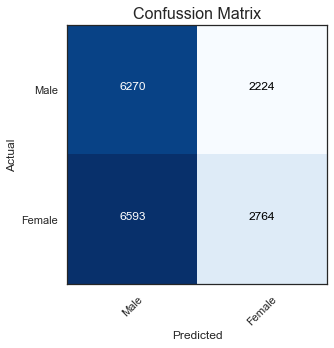

In [279]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Male','Female'], #classes=['No','Yes']
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)
pre = round(tp/(tp + fp), 3)
print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("Log Loss: ",round(metrics.log_loss(ytest,y_dummy_predictions),3))
print("Precision  : ", pre)

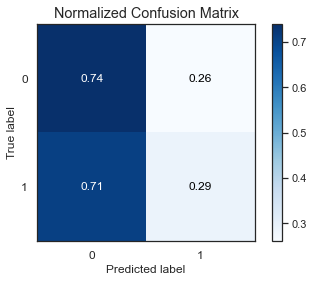

In [297]:
predictions = cross_val_predict(gnb, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

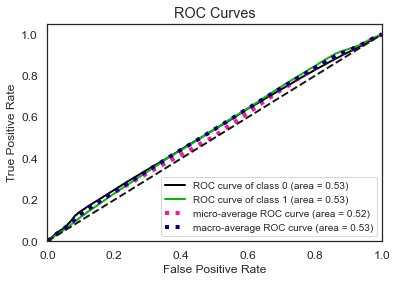

In [299]:
#Para ver con QUÉ probabilidades predijo a cada observacion en 1 o 0
predictions_proba = cross_val_predict(gnb, Xtrain, ytrain,method='predict_proba')
skplt.metrics.plot_roc(y_train, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show()

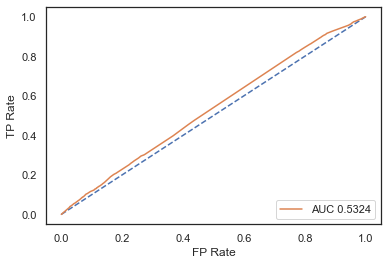

In [280]:
plot_roc(y_test,y_proba)

*Nota*: Para correr los modelos, se intentó agrupar las variables de Sistema Operativo y Navegador, dejando menos valores y agrupando aquellos que presentan pocos casos en categoría 'Otros'. Sin embargo, esto no dio mejores resultados. Por lo tanto, se mantiene el primer feature engeneering realizado.

**Regresión Logística**

In [236]:
penalty = ['l1','l2']
C = [0.001,0.01, 0.1, 1]
solver = ['liblinear'] #o 'saga'

param_grid = dict(penalty=penalty,
                  C=C,
                  solver=solver)

grid_lr = GridSearchCV(estimator=LogisticRegression(),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv = 3, 
                        verbose=4,
                        n_jobs = 12) 

#Fit the model
grid_lr = grid_lr.fit(Xtrain, ytrain)
#Mejores hiperparámetros
grid_lr.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done   8 out of  24 | elapsed:   10.5s remaining:   21.1s
[Parallel(n_jobs=12)]: Done  15 out of  24 | elapsed:   25.6s remaining:   15.3s
[Parallel(n_jobs=12)]: Done  22 out of  24 | elapsed:  1.6min remaining:    8.9s
[Parallel(n_jobs=12)]: Done  24 out of  24 | elapsed:  2.5min finished


{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

Ajustando con mejores hiperparámetros

In [237]:
lr = LogisticRegression(solver='liblinear', C= 0.1, penalty= 'l2')
#Fit the model
lr = lr.fit(Xtrain, ytrain)
#predict
ypred = lr.predict(Xtest)
yproba = lr.predict_proba(Xtest)[:,1]

Accuracy  :  0.545
Recall  :  0.884
Log Loss:  0.688
Precision  :  0.541


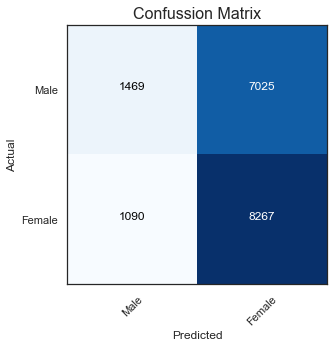

In [238]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Male','Female'], #classes=['No','Yes']
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)
pre = round(tp/(tp + fp), 3)
print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))
print("Precision  : ", pre)

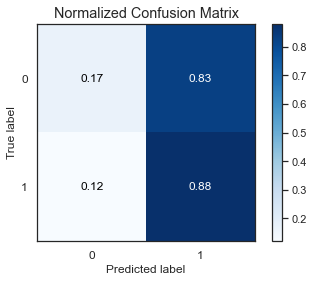

In [239]:
predictions = cross_val_predict(lr, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

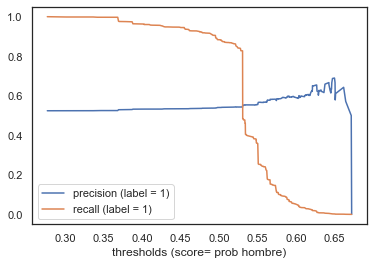

In [241]:
precision_recall_curve_hombre(y_test=ytest,y_proba=yproba)

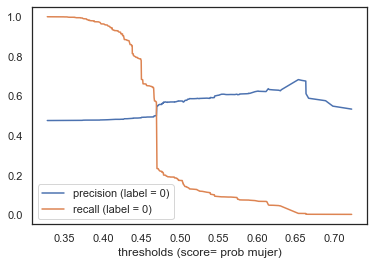

In [242]:
precision_recall_curve_mujer(y_test=ytest,y_proba=yproba)

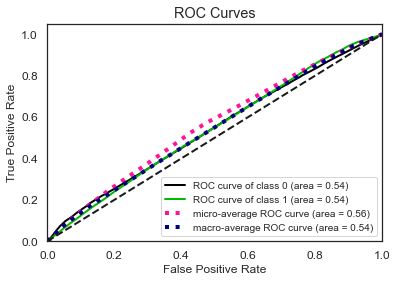

In [300]:
#Para ver con QUÉ probabilidades predijo a cada observacion en 1 o 0
predictions_proba = cross_val_predict(lr, Xtrain, ytrain,method='predict_proba')
skplt.metrics.plot_roc(y_train, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show()

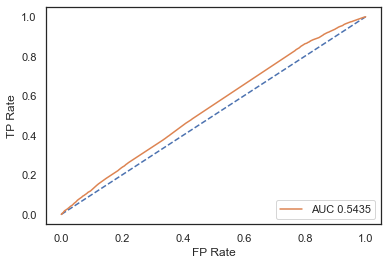

In [243]:
plot_roc(ytest,yproba)

C:\Users\dlongas\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


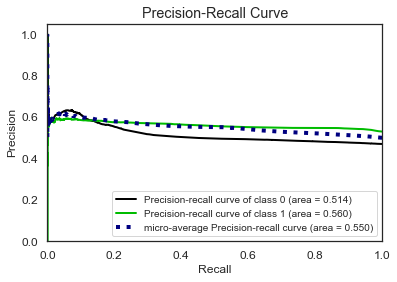

In [244]:
#Para ver con QUÉ probabilidades predijo a cada observacion en 1 o 0
predictions_proba = cross_val_predict(lr, Xtrain, ytrain,method='predict_proba')
skplt.metrics.plot_precision_recall_curve(ytrain, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show();

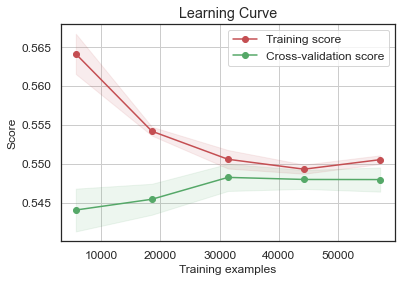

In [245]:
skplt.estimators.plot_learning_curve(lr, Xtrain, ytrain)
plt.show()

In [248]:
lr.coef_

array([[ 0.07,  0.04,  0.16,  0.  ,  0.05,  0.01, -0.1 ,  0.03, -0.05,
        -0.04, -0.08, -0.05,  0.02,  0.04, -0.1 ,  0.18,  0.15,  0.09,
        -0.03, -0.02, -0.05,  0.12,  0.02, -0.08,  0.01, -0.02,  0.02,
        -0.02,  0.1 , -0.06, -0.13, -0.09, -0.  , -0.  ,  0.01,  0.01,
         0.02,  0.02,  0.04,  0.03,  0.03,  0.05,  0.03,  0.01,  0.04,
         0.04,  0.03,  0.04,  0.04,  0.02,  0.  ,  0.01,  0.03,  0.01,
         0.02,  0.01,  0.01,  0.02,  0.03,  0.02,  0.02,  0.02,  0.03,
         0.01,  0.03,  0.02,  0.02,  0.03,  0.03,  0.09,  0.03,  0.01,
         0.06,  0.04,  0.01, -0.01, -0.12, -0.14]])

**Random Forest**

In [281]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(3,12))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf=list(range(1,15))
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
hyperparameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [282]:
# First create the base model to tune
rf = RandomForestClassifier()
##Random Search replaces the exhaustive enumeration of all combinations by selecting them randomly.

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_best_model = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = hyperparameters,
                                   scoring='accuracy', 
                                   n_iter = 50, cv = 3, verbose=4, 
                                   random_state=42, n_jobs = -1) #chequear en que cambia n_jobs

# Fit the random search model
rf_best_model.fit(Xtrain, ytrain)

ypred = rf_best_model.predict(Xtest)
yproba = rf_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.8min finished


In [283]:
#Observo mejores parámetros elegidos
rf_best_model.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

Se utilizarán los mejores parámetros encontrados.

In [284]:
rf=RandomForestClassifier(n_estimators= 100, min_samples_split = 2, min_samples_leaf = 3, 
                          max_features = 'auto',max_depth = None, bootstrap= False)
rf.fit(Xtrain, ytrain)

ypred = rf.predict(Xtest)
yproba = rf.predict_proba(Xtest)[:,1]

# with open(os.path.join('Modelos', 'Genero_random_forrest.pkl'), 'wb') as f:
#         pickle.dump(rf, f)

Accuracy  :  0.547
Recall  :  0.889
Log Loss:  0.688
Precision  :  0.541


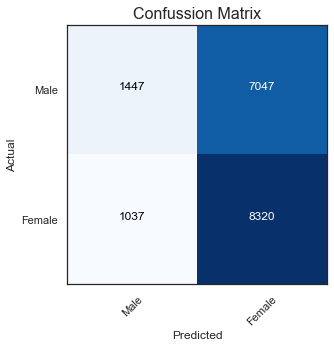

In [285]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Male','Female'], #classes=['No','Yes']
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)
pre = round(tp/(tp + fp), 3)
print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))
print("Precision  : ", pre)

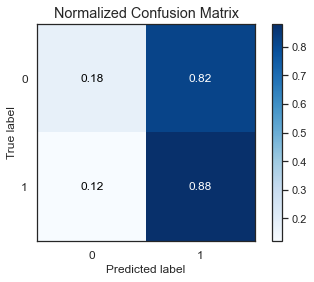

In [286]:
predictions = cross_val_predict(rf, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

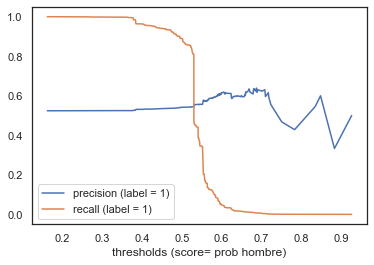

In [287]:
precision_recall_curve_hombre(y_test=ytest,y_proba=yproba)

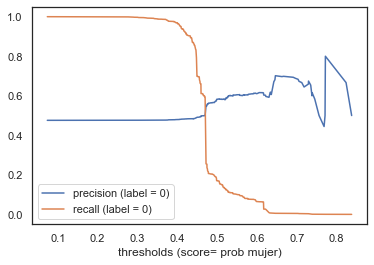

In [288]:
precision_recall_curve_mujer(y_test=ytest,y_proba=yproba)

In [289]:
predictions_proba = cross_val_predict(rf, Xtrain, ytrain,method='predict_proba')
predictions_proba

array([[0.63, 0.37],
       [0.46, 0.54],
       [0.45, 0.55],
       ...,
       [0.38, 0.62],
       [0.45, 0.55],
       [0.55, 0.45]])

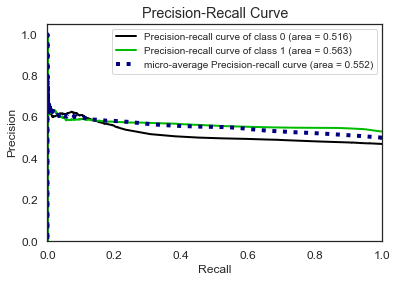

In [290]:
#grafico de curva presicion recall
skplt.metrics.plot_precision_recall(ytrain, predictions_proba) 
plt.legend(loc=0,prop={'size':10})
# detalles de cómo cambiar la leyenda en matplotlib https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
plt.show()

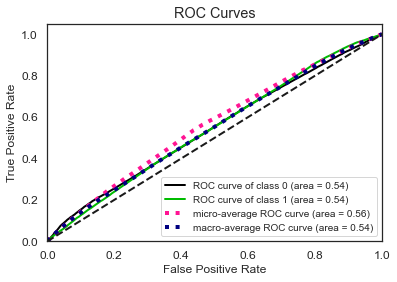

In [301]:
#Para ver con QUÉ probabilidades predijo a cada observacion en 1 o 0
predictions_proba = cross_val_predict(rf, Xtrain, ytrain,method='predict_proba')
skplt.metrics.plot_roc(y_train, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show()

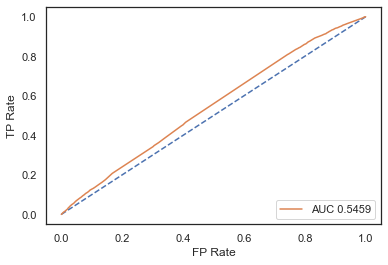

In [291]:
plot_roc(ytest,yproba)

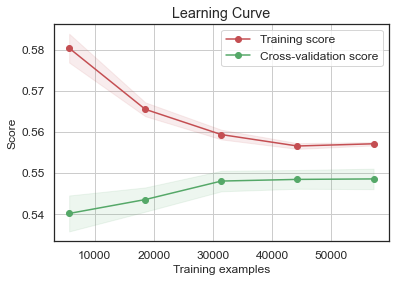

In [246]:
skplt.estimators.plot_learning_curve(rf, Xtrain, ytrain)
plt.show()

In [292]:
rf_fit = rf_best_model.best_estimator_

*Feature Importance*

Feature ranking:
1. feature 23 (0.211251) -> navegador_Firefox
2. feature 21 (0.147994) -> navegador_Chrome
3. feature 28 (0.075404) -> navegador_SocialApp
4. feature 0 (0.029606) -> ispc
5. feature 69 (0.026690) -> modelo_SinDato
6. feature 2 (0.026607) -> ismobile
7. feature 6 (0.020165) -> sistema_op_Windows
8. feature 75 (0.018698) -> antig_ancient
9. feature 18 (0.018632) -> version_sistema_op_Windows XP
10. feature 29 (0.017083) -> marca_ancient
11. feature 3 (0.016199) -> sistema_op_Linux
12. feature 13 (0.015255) -> version_sistema_op_Android 9
13. feature 15 (0.014547) -> version_sistema_op_Windows 10
14. feature 77 (0.013967) -> antig_old
15. feature 62 (0.013409) -> modelo_Samsung SM-J400M
16. feature 27 (0.013062) -> navegador_SinDato
17. feature 31 (0.012627) -> marca_old
18. feature 1 (0.012387) -> istablet
19. feature 41 (0.011218) -> modelo_Samsung SM-A205G
20. feature 76 (0.011045) -> antig_new
21. feature 30 (0.010757) -> marca_new
22. feature 44 (0.010564) -> modelo_

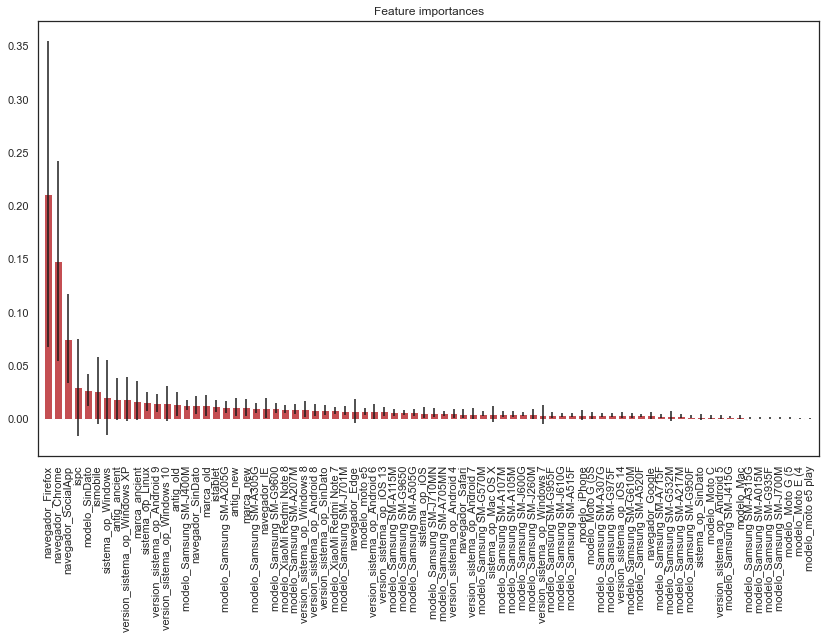

In [293]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

importances = rf_fit.feature_importances_ #rf
std = np.std([tree.feature_importances_ for tree in rf_fit.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

variables=['ispc', 'istablet', 'ismobile', 'sistema_op_Linux',
       'sistema_op_Mac OS X', 'sistema_op_SinDato', 'sistema_op_Windows',
       'sistema_op_iOS', 'version_sistema_op_Android 4',
       'version_sistema_op_Android 5', 'version_sistema_op_Android 6',
       'version_sistema_op_Android 7', 'version_sistema_op_Android 8',
       'version_sistema_op_Android 9', 'version_sistema_op_SinDato',
       'version_sistema_op_Windows 10', 'version_sistema_op_Windows 7',
       'version_sistema_op_Windows 8', 'version_sistema_op_Windows XP',
       'version_sistema_op_iOS 13', 'version_sistema_op_iOS 14',
       'navegador_Chrome', 'navegador_Edge', 'navegador_Firefox',
       'navegador_Google', 'navegador_IE', 'navegador_Safari',
       'navegador_SinDato', 'navegador_SocialApp', 'marca_ancient',
       'marca_new', 'marca_old', 'modelo_Mac', 'modelo_Moto C',
       'modelo_Moto E (4', 'modelo_Moto G (5', 'modelo_Moto G (5S',
       'modelo_Samsung SM-A015M', 'modelo_Samsung SM-A105M',
       'modelo_Samsung SM-A107M', 'modelo_Samsung SM-A115M',
       'modelo_Samsung SM-A205G', 'modelo_Samsung SM-A207M',
       'modelo_Samsung SM-A217M', 'modelo_Samsung SM-A305G',
       'modelo_Samsung SM-A307G', 'modelo_Samsung SM-A315G',
       'modelo_Samsung SM-A505G', 'modelo_Samsung SM-A515F',
       'modelo_Samsung SM-A520F', 'modelo_Samsung SM-A705MN',
       'modelo_Samsung SM-A715F', 'modelo_Samsung SM-G532M',
       'modelo_Samsung SM-G570M', 'modelo_Samsung SM-G610M',
       'modelo_Samsung SM-G935F', 'modelo_Samsung SM-G950F',
       'modelo_Samsung SM-G955F', 'modelo_Samsung SM-G9600',
       'modelo_Samsung SM-G9650', 'modelo_Samsung SM-G975F',
       'modelo_Samsung SM-J260M', 'modelo_Samsung SM-J400M',
       'modelo_Samsung SM-J415G', 'modelo_Samsung SM-J600G',
       'modelo_Samsung SM-J610G', 'modelo_Samsung SM-J700M',
       'modelo_Samsung SM-J701M', 'modelo_Samsung SM-J710MN', 'modelo_SinDato',
       'modelo_XiaoMi Redmi Note 7', 'modelo_XiaoMi Redmi Note 8',
       'modelo_iPhone', 'modelo_moto e5', 'modelo_moto e5 play',
       'antig_ancient', 'antig_new', 'antig_old']
variables_ordenadas=[]

for i in range(0,len(indices)): #TENES IDEA PORQUE NO ME TOMA  range(0,len(indices) ?
    variables_ordenadas.append(variables[indices[i]])
# Print the feature ranking
print("Feature ranking:")

for f in range(0,len(indices)):
    #print("feature {} {} --> {}").format(indices[f], importances[indices[f]], variables_ordenadas[f])
    print("%d. feature %d (%f) -> %s" % (f + 1, indices[f], importances[indices[f]],variables_ordenadas[f]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(14,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), variables_ordenadas)
plt.xlim([-1, X.shape[1]])

x = plt.gca().xaxis
#One specific to text is the set rotation function which changes the rotation based on degrees.
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(90)
    
plt.show()

**XG Boost**

In [115]:
model_xgb = xgb.XGBClassifier(n_jobs=-1)

one_to_left = st.beta(10, 1) #  This distribution will return values between 0 and 1, nearer to 1 #WARNING, NO TENGO CLASES DESB

max_depth = list(range(3,12))
max_depth.append(None)

hyperparameters = {  
    "n_estimators": st.randint(50,200), # Number of boosted trees to fit.
    "max_depth": max_depth,     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
}

xgb_best_model = RandomizedSearchCV(estimator = model_xgb, 
                            param_distributions = hyperparameters,
                            scoring='accuracy', #check
                            n_iter = 50, cv = 3, verbose=4, 
                            random_state=42, n_jobs = -1)
xgb_best_model.fit(Xtrain, ytrain)

ypred = xgb_best_model.predict(Xtest) 
yproba = xgb_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.9min finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [116]:
xgb_best_model.best_params_

{'colsample_bytree': 0.8741814405114897,
 'gamma': 1.8657005888603584,
 'learning_rate': 0.40702359939599114,
 'max_depth': None,
 'min_child_weight': 3.441759094013467,
 'n_estimators': 178,
 'reg_alpha': 2.3293516254194166,
 'subsample': 0.8896274890659086}

Se utilizarán los mejores parámetros encontrados.

In [302]:
xgboost = xgb.XGBClassifier(n_jobs=-1,
                            colsample_bytree = 0.8741814405114897,
                            gamma= 1.8657005888603584,
                            learning_rate=  0.40702359939599114,
                            max_depth = None,
                            min_child_weight= 3.4417590940134677,
                            n_estimators= 178,
                            reg_alpha= 2.3293516254194166,
                            subsample= 0.8896274890659086)

xgboost.fit(Xtrain, ytrain)


y_pred = xgboost.predict(Xtest)
y_proba = xgboost.predict_proba(Xtest)[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:41:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy  :  0.545
Recall  :  0.875
Log Loss:  0.688
Precision  :  0.541


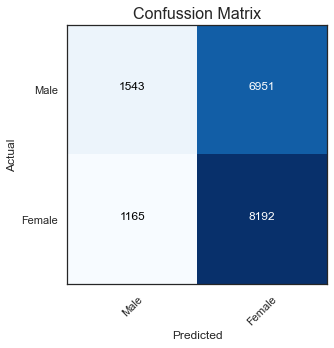

In [303]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, y_pred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Male','Female'], #classes=['No','Yes']
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)
pre = round(tp/(tp + fp), 3)
print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))
print("Precision  : ", pre)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:26:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:26:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

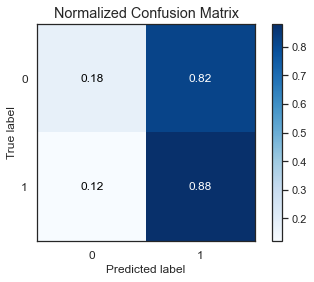

In [296]:
predictions = cross_val_predict(xgboost, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

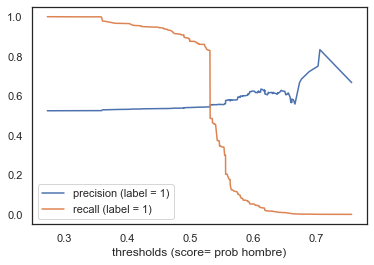

In [160]:
precision_recall_curve_hombre(y_test=ytest,y_proba=y_proba)

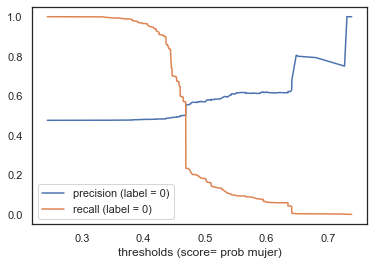

In [161]:
precision_recall_curve_mujer(y_test=ytest,y_proba=y_proba)

In [162]:
predictions_proba = cross_val_predict(xgboost, Xtrain, ytrain,method='predict_proba')
predictions_proba

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:55:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:55:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:55:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([[0.65, 0.35],
       [0.48, 0.52],
       [0.44, 0.56],
       ...,
       [0.39, 0.61],
       [0.45, 0.55],
       [0.55, 0.45]], dtype=float32)

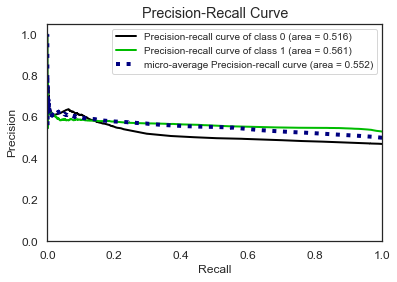

In [164]:
skplt.metrics.plot_precision_recall(ytrain, predictions_proba)
plt.legend(loc=0,prop={'size':10})
# detalles de cómo cambiar la leyenda en matplotlib https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:44:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:44:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:44:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:45:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

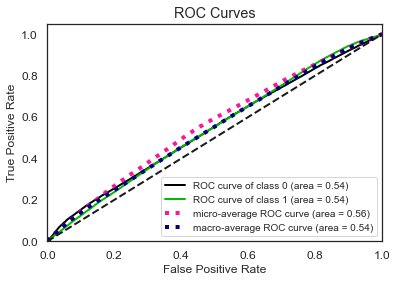

In [304]:
#Para ver con QUÉ probabilidades predijo a cada observacion en 1 o 0
predictions_proba = cross_val_predict(xgboost, Xtrain, ytrain,method='predict_proba')
skplt.metrics.plot_roc(y_train, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show()

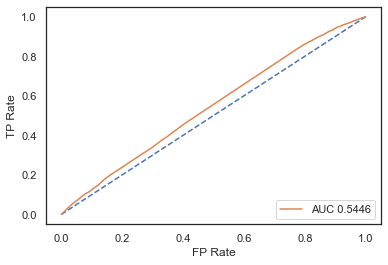

In [121]:
plot_roc(ytest,yproba)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

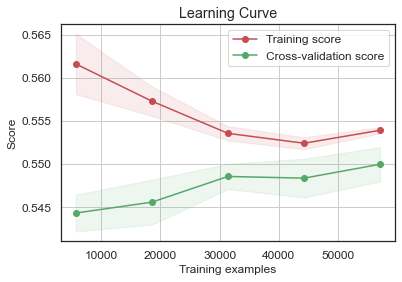

In [247]:
skplt.estimators.plot_learning_curve(xgboost, Xtrain, ytrain)
plt.show()

**Cuadro comparativo de métricas**

|Modelos | Accuracy | AUC | Recall | Precisión | Logloss|   
|--|--|--|--|--|--|   
|Baseline| 0.506 | 0.5324 | 0.295 | **0.554** | 16.435 |  
|Logistic Regression| 0.545 | 0.5435 | 0.884 | 0.541 | **0.688** |  
|**Random Forrest** | **0.548** | **0.5453** | 0.867 | 0.543 | 0.689 |   
|XGBoost | 0.547 | 0.5429 | **0.889** |  0.541 | **0.688** |   

La siguiente tabla que compara distintas métricas en los distintos modelos.
Se observa que el modelo de Random Forest funcionan mejor que el resto. De todos modos la diferencia es ínfima comparado con el mdoelo de XGBoost.